# Idea

I'm curious whether it's possible to reliably predict the outcome of a race given only the past relative rankings of the competitors.

There are a number of approaches to the general problem of ranking. The simplest assume that an item's rank is determined by a single, constant "fitness" score and that a selection of items may be ranked simply by sorting. Such an models are called "pointwise" and typically have $O(N)$ fit parameters assuming $N$ items to rank.

But it's possible, and in many situations likely, for the relative ranking of a pair of items to depend on the other items in the ranking. In the language of the pointwise approach this would require the fitness score to be not a constant, but depend on the subset of items which we are ranking. This is clearly the case in a cycling time trial, where one's level of effort certainly depends on the reputations of the other riders in the race.

A better approach for ranking cyclists may be a "pairwise" model, which assigns a numerical score to each *pair* of riders; for example, the probability of the first rider in the pair ranking ahead of the second. This model has $O(N^2)$ fit parameters and thus can fit more complex relationships. In particular, the ranking decided by a pairwise method will take into account how a rider's effort depends on the other competitors and their ranking.

In [1]:
%pylab inline
%load_ext cython

Populating the interactive namespace from numpy and matplotlib


In [2]:
style.use('notebook.mplstyle')

In [3]:
import pandas as pd
import scipy.stats as stats
from matplotlib.colors import LogNorm
import matplotlib.patheffects as path_effects

# Data cleaning and reduction

For this experiment I collected about 60 MB of JSON data using the [Strava Public API](http://strava.github.io/api/).  To query the API I used a few simple bash scripts and HTTP requests (I was unaware of [stravalib](https://github.com/hozn/stravalib), a Python binding to the Strava API). The data consists of the Strava leaderboards for about 2000 segments in the area of Santa Cruz, CA.

The raw data contains a wealth of data, including rider and segment name and ID, elapsed time, heart rate, power output, etc. Here I'm only interested in the `rank` column, which gives a cyclist's ranking by time on a given segment.

In [4]:
alldata = pd.read_hdf('rankings.h5', 'rankings')[['rank']]
alldata.index.rename(['segment','rider'], inplace=True)

In [5]:
alldata.head()

rank
segment rider      
305     38       47
        163      35
        311      59
        653      20
        1033     94

In [6]:
len(alldata.index.get_level_values('segment').unique())

1892

In [7]:
len(alldata.index.get_level_values('rider').unique())

15018

The raw data contains rankings for about 1900 cyclists and 15000 segments.

I'm most interested in looking at the relationships between the rankings of cyclists who have competed (i.e. ridden on the same segments) many times. Here's what the distribution of total rides looks like...

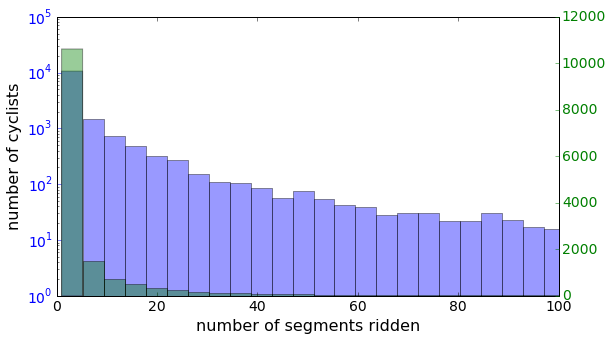

In [8]:
fig, ax1 = subplots()
c1, c2 = tuple('bg')
kw = dict(grid=False, bins=100, alpha=0.4)

num_segments = alldata.groupby(level='rider').size()
num_segments.hist(ax=ax1, color=c1, **kw)
ax1.tick_params(axis='y', colors=c1)
ax1.set_yscale('log')

ax2 = ax1.twinx()
num_segments.hist(ax=ax2, color=c2, **kw)
ax2.tick_params(axis='y', colors=c2)

xlim(0,100)
ax1.set_xlabel('number of segments ridden')
ax1.set_ylabel('number of cyclists');

For the moment I'm interested in only the most well-connected cyclists, so I will take the extreme tail of this distribution, cyclists who have ridden more than 50 segments.

I'm also mainly interested in popular segments, so I keep only segments that have been ridden more than 50 times.

For convenience later on I'm going to replace the values in the `athlete_id` column (currently Strava user IDs) with consecutive integers, ordering the cyclists by increasing average rank (rank averaged over segments).

In [9]:
def reduce_data(data, min_cyclists=20, min_segments=20):

    for i in xrange(2):
        data = data.groupby(level='rider').filter(
            lambda df: len(df) > min_segments)
        data = data.groupby(level='segment').filter(
            lambda df: len(df) > min_cyclists)
    
    # make ranks consecutive
    data['rank'] = data['rank'].groupby(level='segment').rank().astype(int)

    # compute percentile rank
    data['pct'] = (data['rank'].groupby(level='segment')
                               .transform(lambda y: (y-1.)/(max(y) - 1.)))
    
    # relabel cyclists by average rank
    # rename old athlete id -> userid
    data.index = data.index.rename('uid', level='rider')

    # create the new index
    rider = data.pct.groupby(level='uid').mean().rank().astype(int) - 1
    rider.name = 'rider'

    # join and reset index
    data = (data.join(rider).reset_index('uid')
                            .set_index('rider', append=True)
                            .sortlevel())
    
    rank = data[['rank','pct']]
    uid = data.uid.reset_index('segment', drop=True).drop_duplicates()
    
    return rank.sortlevel(), uid

In [10]:
rank, uid = reduce_data(alldata)

In [11]:
rank.head()

rank       pct
segment rider                
305     4         1  0.000000
        8         5  0.088889
        18       15  0.311111
        19        4  0.066667
        20       10  0.200000

Let's look at how many cyclists and segments remain in our data set:

In [12]:
len(rank.index.get_level_values('segment').unique())

1245

In [13]:
len(rank.index.get_level_values('rider').unique())

1351

# Ranking problem

Given the data, a reasonable first approach would be to simply order the riders by their average ranking in past competitions.

The following plot is a 2-d histogram plot with a rider's average rank on the horizontal axis and rank on a specific segment on the vertical.

In [14]:
def plot_rank_hist(**kw):
    
    rank, uid = reduce_data(alldata, **kw) 
    mean_pct = rank.pct.groupby(level='rider').mean()
    mean_pct.name = 'mean_pct'
    rank = rank.join(mean_pct)
    rho = rank.corr().loc['mean_pct','pct'] 

    rank.plot(kind='hexbin', x='mean_pct', y='pct',
              cmap=cm.jet, gridsize=30, norm=LogNorm())

    plot(xlim(), xlim(), color='k')

    txt = text(0.03, 0.97, r'$\rho={:.2f}$'.format(rho),
               size='large', ha='left', va='top', 
               transform=gca().transAxes)

    txt.set_path_effects([path_effects.Stroke(linewidth=3, foreground='w'),
                          path_effects.Normal()])

    xlabel('average rank')
    ylabel('rank')

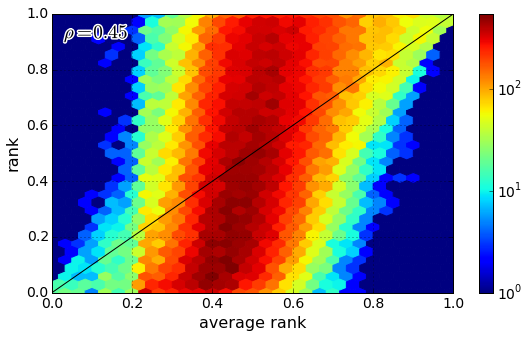

In [15]:
plot_rank_hist(min_segments=1, min_cyclists=1)

In [16]:
rank.pct.groupby(level='rider').agg(['mean','std']).head()

,mean,std
rider,,
0,0.163115,0.271067
1,0.244307,0.225259
2,0.250029,0.300396
3,0.250188,0.296795
4,0.254945,0.258049


The variance is huge! It's unlikely that we'll have much success using this method alone, but it might be a useful approximation to build on.

One of the limitations of this method is that it's a 
[pointwise](http://en.wikipedia.org/wiki/Learning_to_rank#Pointwise_approach) 
approach: it assigns a numerical score to each item to be ranked and the ranking is done by comparison of scores.

Pointwise methods will likely have trouble with a data set such as this one where the variance in numerical scores can be large. In this example, cyclists have various strengths and weaknesses that may equip them for better results on certain segments than others. Additionally, the level of effort a cyclist puts into placing well on a given segment is nowhere near constant, but often depends on how his peers have placed.

A better approach in this case might be a 
[pairwise](http://en.wikipedia.org/wiki/Learning_to_rank#Pairwise_approach)
approach, in which we assign scores to pairs of items, for example the probability that one rider will place higher than the other. The ranking is then done by minimizing the number of inversions. Pairwise methods typically have $O(N^2)$ parameters to fit (as opposed to $O(N)$ for pointwise), so they are able to fit more complex relationships.

# Model

It's now convenient to introduce some notation. Let $W_{ij}$ be the probability that $y_i < y_j$, where $y_i$ is the rank of rider $i$. Define the $N \times N$ matrix $W$ by

$$W_{ij} \equiv 2 P_{ij} - 1$$

where $P_{ij}=P(y_i<y_j)$. Then define a **cost function**

$$C(y; W) = -\sum_{y_i<y_j} W_{ij}$$

# Training

To train this model we estimate the comparison matrix $W$ from the data. The first step is to count the number of wins and matches for each pair of riders. The following function updates the totals given ranking data for a single segment:

In [17]:
%%cython

cimport numpy as np

cpdef update(np.int64_t [:] leaders, 
             np.int64_t [:,:] wins, 
             np.int64_t [:,:] matches):
    
    """Update wins and matches counts given the ranking for a segment"""
    
    cdef int i, j, yi, yj, n = len(leaders)
    
    for yi in range(n):
        for yj in range(yi+1, n):
            i = leaders[yi]
            j = leaders[yj]
            if i < j:
                wins[i, j] += 1
                matches[i, j] += 1
            else:
                wins[j, i] -= 1
                matches[j, i] += 1

## Estimating $W_{ij}$ from the data

What's the best way to estimate $W_{ij}$ from the data? We could take the frequentist approach and simply use the sample mean

$$
\overline{W}_{ij}
=\frac{(\text{number of times $i$ won})-(\text{number of times $j$ won})}
      {(\text{number of times $i$ and $j$ competed})}.
$$

But a given pair of riders may only be matched a few times and we may well have cases where $i$ has lost every competition against $j$ and we end up with $P_{ij}=0$. Trivially this can cause problems if we want to, for example, compute $\log P_{ij}$. But a better reason to avoid this is we would like $P_{ij}$ to reflect our level of certainty that $i$ should rank above $j$, which *increases* with the number of data points.

A better choice might be the *maximum a posteriori* (MAP) estimate assuming a normal prior,

$$
W^{\text{MAP}} = \alpha \overline{W} + (1-\alpha) \mu
$$

$$
\alpha = \frac{N}{N + s^2/\sigma^2}
$$

where $s^2$ is the variance of the data and $\mu$, $\sigma^2$ are the mean and variance of a prior normal distribution. The MAP estimate can be thought of as interpolating between the prior mean and the sample mean, getting closer to the sample mean as the number of data points increases. The ratio $s^2/\sigma^2$ controls how fast this happens.

A reasonable initial choice for the prior distribution is the normal with mean 0 and variance 1.

In [18]:
def train(rank, prior_mean=0., prior_var=1.):
  
    rider = (rank.reset_index('rider')
                 .set_index('rank', append=True)
                 .rider)
    
    num_athletes = len(rider.unique())
    W = zeros((num_athletes,)*2, dtype=int)
    M = zeros((num_athletes,)*2, dtype=int)

    for sid, df in rider.groupby(level='segment'):
        leaders = df.sortlevel('rank').values
        update(leaders, W, M)
        
    M += M.T
    W -= W.T
    
    # compute MAP for gaussian prior
    sample_mean = where(M != 0, W/M.astype(float), 0.)
    alpha = M/(M + 1./prior_var)
    W = alpha*sample_mean + (1-alpha)*prior_mean
    
    return W, M

In [19]:
W, M = train(rank)

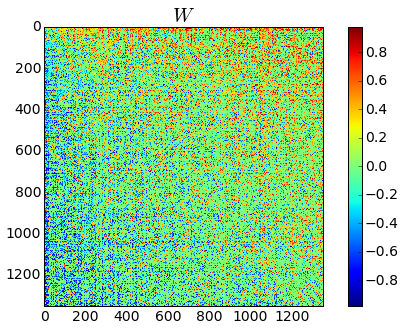

In [20]:
imshow(W, interpolation='nearest')
colorbar();
title('$W$');

## Better values for the prior mean

Above we chose the mean of the prior distribution $\mu=0$. Thus, if $i$ and $j$ never competed, our estimate for the expected number of wins of $i$ versus $j$ would have been $W_{ij}^{\text{MAP}}=0$. But of course we can do better by considering $i$'s and $j$'s average performance against other riders.

Assume a cyclist $i$'s percentile ranking $X_i$ is normally distributed with mean $\mu_i$ and variance $\sigma^2_i$:

$$
X_i = \text{N}(\mu_i,\, \sigma^2_i)
$$

Then, assuming $X_i$ and $X_j$ are iid, the difference $X_i-X_j$ is also normally distributed:

$$
\Delta_{ij} \equiv X_j - X_i 
= \text{N}(\mu_i - \mu_j,\, \sigma^2_i + \sigma^2_j)
\equiv \text{N}(\mu_{ij},\, \sigma^2_{ij})
$$

Thus a better prior might be the probability that $X_i<X_j$, given by

$$
P_{ij} 
\equiv P(X_i < X_j) 
= P(\Delta_{ij} < 0) 
= \Phi(-\mu_{ij}/\sigma_{ij})
$$

where $\Phi(x)$ is the cdf of the standard normal distribution.

In [21]:
def prior_mean(rank):
    
    df = rank.pct.groupby(level='rider').agg(['mean','std'])
    xprod = pd.MultiIndex.from_product((df.index,)*2)
    
    mu = [df['mean'].reindex(xprod, level=_) for _ in (0,1)]
    mu = mu[0] - mu[1]
    
    sigma = [df['std'].reindex(xprod, level=_) for _ in (0,1)]
    sigma = sqrt(sigma[0]**2 + sigma[1]**2)
    
    P = stats.norm.cdf(-mu/sigma)
    P = P.reshape((len(df), len(df)))
    
    return 2*P - 1

In [22]:
P = prior_mean(rank)
W, M = train(rank, P)

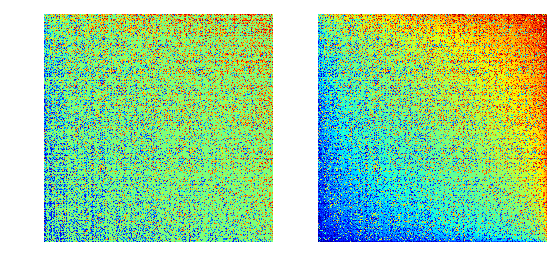

In [23]:
fig, axs = subplots(1, 2)

for ax, P_ in zip(axs, [0., P]):
    W_, _ = train(rank, P_)
    ax.imshow(W_, interpolation='nearest')
    ax.axis('off')

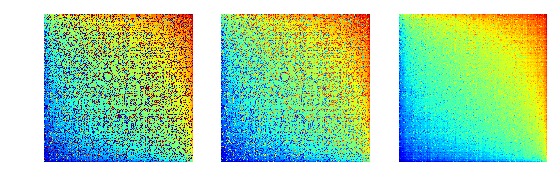

In [24]:
fig, axs = subplots(1, 3)

for ax, var in zip(axs, [10, 1, 0.1]):
    W_, _ = train(rank, P, var)
    ax.imshow(W_, interpolation='nearest')
    ax.axis('off')

In [25]:
def train2(rank, **kw):
    P = prior_mean(rank)
    return train(rank, P, **kw)

## Powers of $P$

$$
(P^2)_{ij} = \sum_k P_{ik} P_{kj} = \sum_k P(y_i < y_k) P(y_k < y_j)
$$

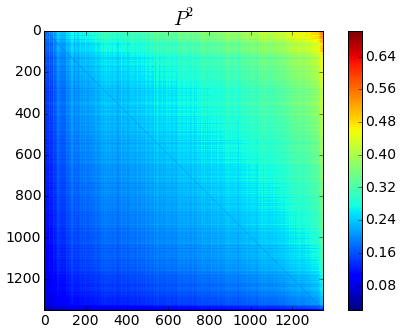

In [26]:
P = 0.5*(W + 1)
P2 = np.dot(P, P)/P.shape[0]
imshow(P2, interpolation='nearest')
colorbar()
title('$P^2$');

# Testing the cost function

In [27]:
def cost(W, u):
    s = sum(W[i,j] for yi, i in enumerate(u) for j in u[yi+1:])
    nt = len(u)*(len(u)-1)/2.
    return -s/nt

In [28]:
rider = (rank.reset_index('rider')
             .set_index('rank', append=True)
             .rider)

groups = rider.groupby(level='segment')

actual = groups.agg(
    lambda u: cost(W, u.sortlevel('rank').values))
shuffled = groups.agg(
    lambda u: cost(W, random.choice(u.values, len(u), replace=False)))
pointwise = groups.agg(
    lambda u: cost(W, u.sort(inplace=False).values))

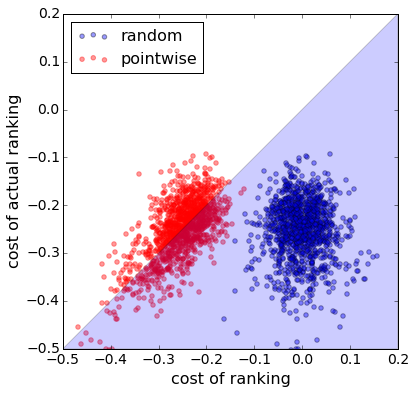

In [29]:
figure(figsize=(6,6))
kw = dict(alpha=0.4)
scatter(shuffled, actual, label='random', **kw)
scatter(pointwise, actual, label='pointwise', color='r', **kw)
xlim(-0.5, 0.2)
ylim(-0.5, 0.2)
fill_between(xlim(), xlim(), ylim()[0], alpha=0.2)
xlabel('cost of ranking')
ylabel('cost of actual ranking')
legend(loc=2);

# Optimizing the ranking

Now that we have estimated $W$ and found a suitable cost function, the final step is to optimize the cost function to generate a predicted ranking. While this is trivial for a pointwise model (just sort items by their score), it is can be quite complex for a pairwise model. Here I will go with a "big hammer" general-purpose stochastic optimization algorithm to minimize the cost function.

## Extremal optimization (EO)

[Extremal optimization](http://en.wikipedia.org/wiki/Extremal_optimization) 
(Boettcher et al, 2002)
is a relatively simple stochastic optimization algorithm which provides good results for a wide range of combinatorial optimization problems and only has a single parameter to tune. For our problem, each iteration of the algorithm consists of the following steps:

1. For each pair of adjacently-ranked athletes, compute the cost of a swap $\Delta C_{i,\,i+1}$
2. Sort potential swaps by cost, lowest to highest
3. Do the $k$th swap in the list with probability $k^{-\tau}$

I've implemented the algorithm in a Cython extension module [`stravarank`](https://github.com/mcwitt/strava-ranking/blob/master/stravarank/stravarank.pyx).

In [30]:
from stravarank import XOpt, RankingProblem

Test the algorithm on the a single segment with 46 results:

In [31]:
sid = rank.index.get_level_values('segment').unique()
df = rank.loc[sid[0]]
uact = df['rank'].sort(inplace=False).values
yact = uact.argsort() + 1

# start with a random initial configuration
u = uact.copy()
shuffle(u)

In [32]:
len(u)

46

In [33]:
%%time
xo = XOpt(RankingProblem(W, u), tau=1.2)
niter = [2**i for i in range(1,20)]
result = []

for n in niter:
    xo.optimize(niter=n)
    result.append((xo.best, xo.cbest))

CPU times: user 5.33 s, sys: 18.8 ms, total: 5.34 s
Wall time: 5.36 s


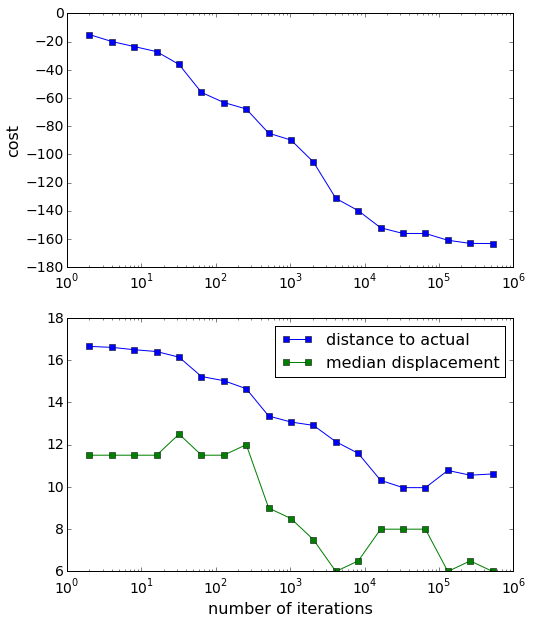

In [34]:
fig, ax = subplots(2, 1, figsize=(8,10))
kw = dict(marker='s')

uvt = zip(*result)[0]
cvt = zip(*result)[1]
dyvt = array([u.argsort() - yact for u in uvt])

ax[0].plot(niter, cvt, **kw)
ax[0].set_ylabel('cost')

ax[1].plot(niter, sqrt(mean(dyvt**2, axis=1)), 
           label='distance to actual', **kw)

ax[1].plot(niter, median(abs(dyvt), axis=1),
           label='median displacement', **kw)

for a in ax: 
    a.set_xscale('log')

ax[1].set_xlabel('number of iterations')
legend(loc=1);

# Cross validation

In [35]:
segments = rank.index.get_level_values('segment').unique()
shuffle(segments)

strain = segments[:len(segments)/2]
stest  = segments[len(segments)/2:]

rank_train = rank.reindex_axis(strain, level='segment')
rank_test  = rank.reindex_axis(stest,  level='segment')

In [36]:
W, M = train2(rank_train)

In [37]:
def predict(W, u, niter=10000, **kw):
    xo = XOpt(RankingProblem(W, u), **kw)
    xo.optimize(niter)
    nt = len(u)*(len(u)-1)/2.
    ubest = xo.best
    ybest = ubest.argsort() + 1
    return ubest, ybest, xo.cbest/nt

In [38]:
rider = (rank_test.reset_index('rider')
                  .set_index('rank', append=True)
                  .rider)

groups = rider.groupby(level='segment')

cost_actual = groups.agg(
    lambda u: cost(W, u.sortlevel('rank').values))
cost_shuffled = groups.agg(
    lambda u: cost(W, random.choice(u.values, len(u), replace=False)))
cost_pointwise = groups.agg(
    lambda u: cost(W, u.sort(inplace=False).values))
cost_pairwise = groups.agg(
    lambda u: predict(W, u.values, tau=1.2)[2])

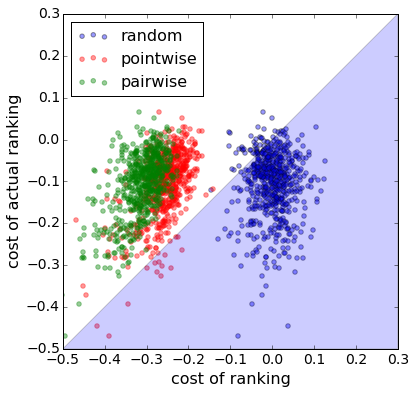

In [39]:
figure(figsize=(6,6))
kw = dict(alpha=0.4)
scatter(cost_shuffled,  cost_actual, label='random', **kw)
scatter(cost_pointwise, cost_actual, label='pointwise', color='r', **kw)
scatter(cost_pairwise,  cost_actual, label='pairwise', color='g', **kw)
xlim(-0.5, 0.3)
ylim(-0.5, 0.3)
fill_between(xlim(), xlim(), ylim()[0], alpha=0.2)
xlabel('cost of ranking')
ylabel('cost of actual ranking')
legend(loc=2);

In [40]:
def dist(u, v):
    return sqrt(sum((u-v)**2))/len(u)

In [41]:
rank.head()

rank       pct
segment rider                
305     4         1  0.000000
        8         5  0.088889
        18       15  0.311111
        19        4  0.066667
        20       10  0.200000

In [42]:
groups = rank_test['rank'].groupby(level='segment')

dist_pointwise = groups.agg(
    lambda y: dist(y.values, arange(len(y)) + 1))

dist_pairwise = groups.agg(
    lambda y: dist(y.values, predict(W, y.index.get_level_values('rider').values, tau=1.2)[1]))

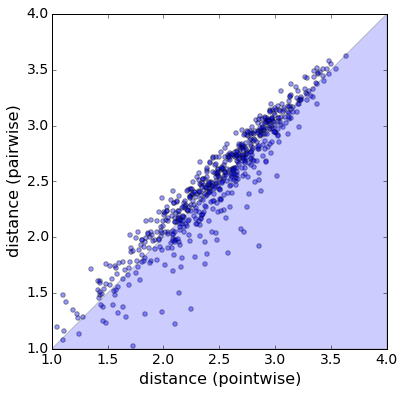

In [43]:
figure(figsize=(6,6))
kw = dict(alpha=0.4)
scatter(dist_pointwise, dist_pairwise, **kw)
xlim(1, 4)
ylim(1, 4)
fill_between(xlim(), xlim(), ylim()[0], alpha=0.2)
xlabel('distance (pointwise)')
ylabel('distance (pairwise)');